In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

import plotly.express as px
import plotly as plt
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "vscode" # to be replaced by "iframe" if working on JULIE

# IMPORT DATASET

In [4]:
df_original=pd.read_csv('Walmart_Store_sales.csv')

In [5]:
#make a copy to work on it
df=df_original.copy()

In [6]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


# Explore dataset

In [7]:
#Basic stats
print("Number of rows : {}".format(df.shape[0]))
print("Number of columns : {}".format(df.shape[1]))
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 150
Number of columns : 8

Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

# Study outliers

In [8]:
# We fix as outlier all the values up to the mean + 3 times the standard deviation for each feature

max_Temp=df['Temperature'].mean() + 3*df['Temperature'].std()
max_Fuel=df['Fuel_Price'].mean() + 3*df['Fuel_Price'].std()
max_CPI=df['CPI'].mean() + 3*df['CPI'].std()
max_Unempl=df['Unemployment'].mean() + 3*df['Unemployment'].std()
print('we can consider as outliers, values up to: ')
print(f'Temperature = {max_Temp}, Fuel_Price = {max_Fuel}, CPI = {max_CPI}, Unemployment = {max_Unempl}')

we can consider as outliers, values up to: 
Temperature = 116.53480791969432, Fuel_Price = 4.75530003695527, CPI = 300.7233775900417, Unemployment = 12.329947132356104


In [10]:
# We fix as outlier all the values less than the mean + 3 times the standard deviation for each feature

min_Temp=df['Temperature'].mean() - 3*df['Temperature'].std()
min_Fuel=df['Fuel_Price'].mean() - 3*df['Fuel_Price'].std()
min_CPI=df['CPI'].mean() - 3*df['CPI'].std()
min_Unempl=df['Unemployment'].mean() - 3*df['Unemployment'].std()
print('we can consider as outliers, values less than: ')
print(f'Temperature = {min_Temp}, Fuel_Price = {min_Fuel}, CPI = {min_CPI}, Unemployment = {min_Unempl}')

we can consider as outliers, values less than: 
Temperature = 6.261404201517784, Fuel_Price = 1.8864058453976682, CPI = 59.073639844740796, Unemployment = 2.8669121269031557


<AxesSubplot:xlabel='Unemployment'>

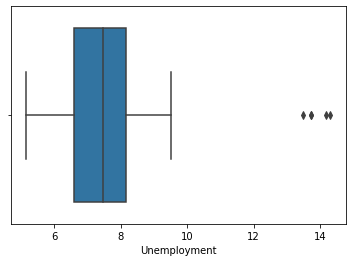

In [8]:
# Outliers vizualization
sns.boxplot(x=df["Unemployment"])

In [11]:
#We check how many rows with null value as target y (Weekly_Sales)
df['Weekly_Sales'].isnull().sum()

14

In [4]:
# We drop these rows
df=df.dropna(subset = ['Weekly_Sales'])
df.Weekly_Sales.isnull().sum()

0

In [5]:
df.shape

(136, 8)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         136 non-null    float64
 1   Date          118 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  125 non-null    float64
 4   Temperature   121 non-null    float64
 5   Fuel_Price    124 non-null    float64
 6   CPI           125 non-null    float64
 7   Unemployment  122 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.6+ KB


In [6]:
#How many rows I'll drop = 5
(df['Unemployment'] > df['Unemployment'].mean() + 3*df['Unemployment'].std()).value_counts()

False    131
True       5
Name: Unemployment, dtype: int64

In [7]:
# Dropping outliers in Unemployment feature (using masks) (we keep the null values here)

print('Dropping outliers in Unemployment...')
to_keep = (df['Unemployment'] < (df['Unemployment'].mean() + 3*df['Unemployment'].std())) | (df['Unemployment'].isnull())
df = df.loc[to_keep,:]
print('Done. Number of lines remaining : ', df.shape[0])
print()


Dropping outliers in Unemployment...
Done. Number of lines remaining :  131



In [8]:
#let's have a look to our feature "date"
df['Date']

0      18-02-2011
1      25-03-2011
3             NaN
4      28-05-2010
5      28-05-2010
          ...    
145    18-06-2010
146           NaN
147    11-06-2010
148    12-08-2011
149    20-04-2012
Name: Date, Length: 131, dtype: object

In [9]:
#We will split this column by creating column for each: day, year, month.... 
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df=df.drop(columns=['Date'])
df.head()

/var/folders/t3/rkks8m514635lhc10vfq7kn80000gn/T/ipykernel_2288/2560001964.py:2: UserWarning:

Parsing '18-02-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/t3/rkks8m514635lhc10vfq7kn80000gn/T/ipykernel_2288/2560001964.py:2: UserWarning:

Parsing '25-03-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/t3/rkks8m514635lhc10vfq7kn80000gn/T/ipykernel_2288/2560001964.py:2: UserWarning:

Parsing '28-05-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/t3/rkks8m514635lhc10vfq7kn80000gn/T/ipykernel_2288/2560001964.py:2: UserWarning:

Parsing '19-08-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/t3/rkks8m514635lhc10vfq7kn80000gn/T/ipykernel_2288/2560001964.py:2: UserWarning:

Parsing '15-10-2010' in DD/MM/YYYY format

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN,NaN
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010.0,5.0,28.0,4.0


In [10]:
fig = px.histogram(x = df['Weekly_Sales'], nbins = 120, title = "Distribution of target variable")

fig.show()

In [11]:
first_df=df.iloc[:,:7]
first_df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896


In [20]:
# Visualize pairwise dependencies
fig = px.scatter_matrix(df)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height = 1200, width = 1200)
fig.show()

In [21]:
# Visualize pairwise dependencies without colums day/month/year/day-of-week
fig = px.scatter_matrix(first_df)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height = 1200, width = 1200)
fig.show()

In [22]:
# Univariate analysis
# Distribution of each numeric variable
num_features = ['Weekly_Sales', 'Fuel_Price', 'Temperature', 'CPI', 'Unemployment']
for i in range(len(num_features)):
    fig = px.histogram(df[num_features[i]])
    fig.show()


<AxesSubplot:xlabel='DayOfWeek', ylabel='Weekly_Sales'>

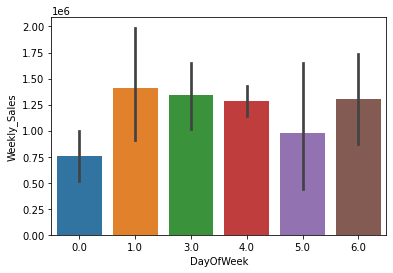

In [23]:
sns.barplot(data=df, x="DayOfWeek", y="Weekly_Sales" )

<AxesSubplot:xlabel='Month', ylabel='Weekly_Sales'>

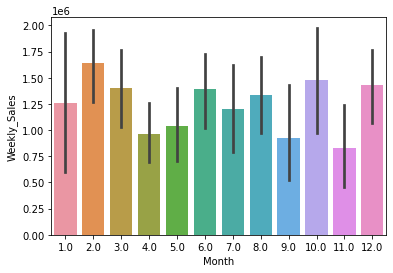

In [24]:
sns.barplot(data=df, x="Month", y="Weekly_Sales" )

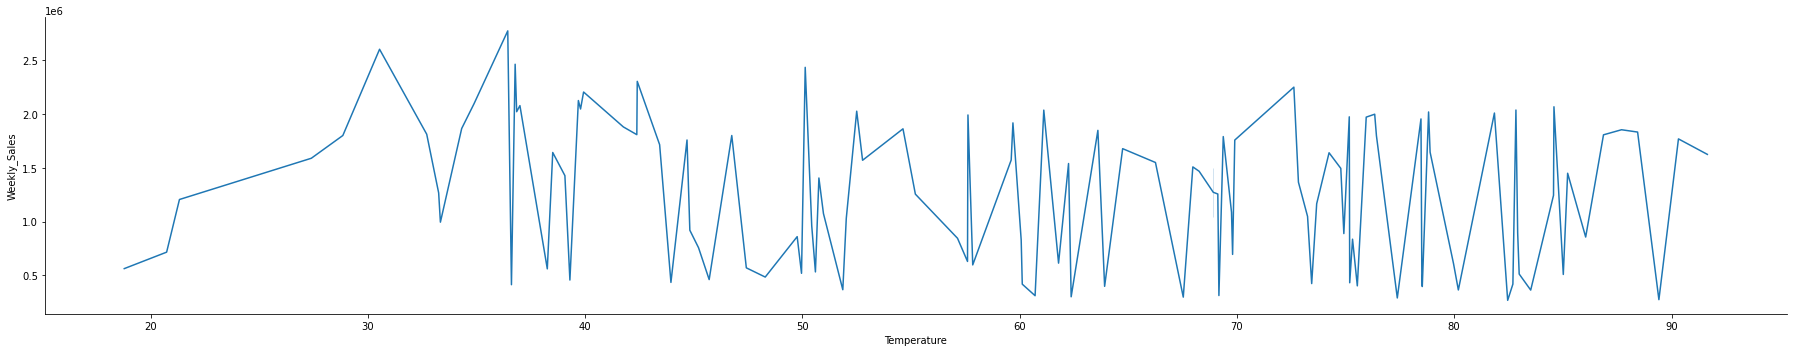

In [25]:
sns.relplot(x="Temperature", y="Weekly_Sales", data = df, kind="line", height = 5, aspect = 5)
#sns.catplot(data=df, x="Temperature", y="Weekly_Sales", kind="boxen")

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

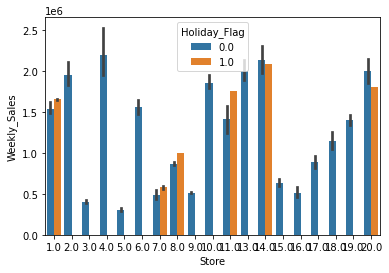

In [26]:
#sns.relplot(x="Store", y="Weekly_Sales", data = df, kind="line", height = 5, aspect = 5)
sns.barplot(data=df, x="Store", y="Weekly_Sales", hue='Holiday_Flag')


In [27]:
# Correlation matrix
corr_matrix = df.corr().round(2)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()


In [29]:
df.columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'DayOfWeek'],
      dtype='object')

In [12]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'
features_list = ["Store","Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment","Year","Month","Day","DayOfWeek"]


X = df.loc[:,features_list]
Y = df.loc[:,target_name]
print("Separating labels from features...")
Y = df.loc[:,target_name]
X = df.drop(target_name, axis = 1) # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()


Separating labels from features...
...Done.
0    1572117.54
1    1807545.43
3    1244390.03
4    1644470.66
5    1857533.70
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           NaN        59.61       3.045  214.777523         6.858   
1   13.0           0.0        42.38       3.435  128.616064         7.470   
3   11.0           0.0        84.57         NaN  214.556497         7.346   
4    6.0           0.0        78.89       2.759  212.412888         7.092   
5    4.0           0.0          NaN       2.756  126.160226         7.896   

     Year  Month   Day  DayOfWeek  
0  2011.0    2.0  18.0        4.0  
1  2011.0    3.0  25.0        4.0  
3     NaN    NaN   NaN        NaN  
4  2010.0    5.0  28.0        4.0  
5  2010.0    5.0  28.0        4.0  



In [13]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [16]:
#Categorical variables : Store, Holiday_Flag, DayOfWeek
#Numerical variables : Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day
# Create pipeline for numeric features
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'] # Names of numeric columns in X_train/X_test
date_features = ['Year', 'Month','Day', 'DayOfWeek']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),# missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])
numeric_transformer_date = Pipeline(steps=[
    ('imputer', KNNImputer()),# missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])


In [17]:
# Create pipeline for categorical features
categorical_features = ['Store', 'Holiday_Flag'] # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])


In [19]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('date',numeric_transformer_date, date_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [20]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()


Performing preprocessings on train set...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
136    4.0           NaN        84.59       3.469  129.112500         5.644   
78     1.0           0.0        62.25       3.308  218.220509         7.866   
17    18.0           0.0        21.33       2.788  131.527903         9.202   
108   18.0           0.0        69.12       2.906  132.293936           NaN   
141    5.0           0.0        62.37         NaN  212.560411         6.768   

       Year  Month   Day  DayOfWeek  
136  2011.0    8.0   7.0        6.0  
78   2011.0   11.0  18.0        4.0  
17      NaN    NaN   NaN        NaN  
108  2010.0    5.0  28.0        4.0  
141  2010.0   12.0  11.0        5.0  
...Done.
[[ 1.46315567e+00  3.08069570e-01 -1.35931117e+00 -1.84213463e+00
   1.93027545e-01  3.80851907e-01 -1.18560403e+00  1.88215879e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+0

In [21]:
#Baseline Model: Linear Regression =>Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [22]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[2203144.29528368 1588260.69291146 1178616.44442075 1243403.4687425
  360018.716885    825907.31072928 2097915.1121703  2010164.74124339
  414925.55524857 2120142.61711358 1419328.77067703  459414.09369597
 1975762.18874643 1550322.20201212 1448332.72719884 1980555.03830889
 2082032.29022885 2015085.91952109 1616443.96804619 1908305.91514556
 2009025.48194585 1784513.45998471 2012356.44065502  617712.49351734
 1554391.13159897  600058.97990698 1471572.77126765  532105.78030742
  450588.35395998 2012902.66304417 1319546.81671945 1011325.79375404
 1868966.41741417 2055902.10028424 1385824.63884251 1905705.68798286
 1963210.06184372 1031837.80118344  478251.80567057  284015.70810851
 2002363.0299927  1977112.46364383 1558407.01204015  624515.80618957
 1618869.09668948 1487076.38239309  166090.58749812 1549025.38810052
 2093222.09204155  631880.95447945 2059727.18897252  846412.37745934
  379857.60446016  983821.79373687 1989122.58253326 1394533.3039

In [23]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[ 424055.04486978  503694.70724986 1065676.21983814  940177.96701307
  339774.95835507 1896256.24372454 1457640.82149171 1036604.92557364
 1141977.91706098  891683.38065463 1848734.74010978 2388546.47825096
 1349808.52519567  765128.51455859 1190144.69806183  313304.6032022
 2292399.60123916  336142.17564432 1582834.85264956 1959089.23678934
  892238.45541036  452064.61226883  287141.3873518  1990878.23032167
 1997162.8801009  1681321.08023674  122877.08361798]



In [24]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9690974207919347
R2 score on test set :  0.9374396100294388


In [40]:
#Nous obtenons un R2 supérieur sur le Train, nous sommes peut etre en overfitting
print("Allons vérifier si cette différence entre le score train et test est significative")

In [25]:
#Cross Validation
print("3-fold cross-validation...")
scores = cross_val_score(regressor, X_train, Y_train, cv=5)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())


3-fold cross-validation...
The cross-validated R2-score is :  0.932246610352669
The standard deviation is :  0.023244965227990938


In [42]:
print('Nous avons obtenu un score R2 test de: {} or ce score + notre écart type sur les différents scores obtenus avec notre Cross Validation reste inférieur à notre score R2 train de : {}'.format((round(r2_score(Y_test, Y_test_pred),5)),(round(r2_score(Y_train, Y_train_pred),5))))
print('Nous sommes donc bel et bien en overfitting')

Nous avons obtenu un score R2 test de: 0.93744 or ce score + notre écart type sur les différents scores obtenus avec notre Cross Validation reste inférieur à notre score R2 train de : 0.9691
Nous sommes donc bel et bien en overfitting


In [41]:
regressor.coef_

array([  -29889.63488091,   -29972.25858323,    92112.1066835 ,
         -94254.86346719,   -35393.12400149,    37030.35187209,
         -28117.86944173,    -2354.55531401,   365545.57972288,
       -1233006.69806167,   656944.99253022, -1395973.31665376,
         -54136.32064883,  -888385.53196512,  -848966.90453811,
       -1276808.31256484,   684020.96628748,    42586.24230568,
         581400.17334717,   675336.35568495,  -663814.80220216,
       -1111788.0573481 ,  -624940.95250283,  -133201.6072677 ,
          94627.95922619,   377686.17189415,   -73525.48935808])

In [42]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)


Names of columns corresponding to each coefficient:  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'DayOfWeek', 'x0_2.0', 'x0_3.0', 'x0_4.0', 'x0_5.0', 'x0_6.0', 'x0_7.0', 'x0_8.0', 'x0_9.0', 'x0_10.0', 'x0_11.0', 'x0_13.0', 'x0_14.0', 'x0_15.0', 'x0_16.0', 'x0_17.0', 'x0_18.0', 'x0_19.0', 'x0_20.0', 'x1_1.0']


In [43]:
# Create a pandas DataFrame
coefs_Lin = pd.DataFrame(index = column_names, data = regressor.coef_.transpose(), columns=["coefficients"])
coefs_Lin

,coefficients
Temperature,-2.988963e+04
Fuel_Price,-2.997226e+04
CPI,9.211211e+04
Unemployment,-9.425486e+04
Year,-3.539312e+04
Month,3.703035e+04
Day,-2.811787e+04
DayOfWeek,-2.354555e+03
x0_2.0,3.655456e+05
x0_3.0,-1.233007e+06


In [44]:
# Compute abs() and sort values
feature_importance = abs(coefs_Lin).sort_values(by = 'coefficients')
feature_importance

,coefficients
DayOfWeek,2.354555e+03
Day,2.811787e+04
Temperature,2.988963e+04
Fuel_Price,2.997226e+04
Year,3.539312e+04
Month,3.703035e+04
x0_11.0,4.258624e+04
x0_6.0,5.413632e+04
x1_1.0,7.352549e+04
CPI,9.211211e+04


In [45]:
fig = px.bar(feature_importance)
fig.show()

In [46]:
#Part 3 : Fight overfitting=>Ridge
Ridge1 = Ridge()

Ridge1.fit(X_train, Y_train)
# Print R^2 scores
print("R2 score on training set : ", Ridge1.score(X_train, Y_train))
print("R2 score on test set : ", Ridge1.score(X_test, Y_test))


R2 score on training set :  0.9290743181924256
R2 score on test set :  0.9075293388096282


In [47]:
#Part 3 : Fight overfitting=>Ridge
Ridge2 = Ridge(alpha = 5)

Ridge2.fit(X_train, Y_train)
# Print R^2 scores
print("R2 score on training set : ", Ridge2.score(X_train, Y_train))
print("R2 score on test set : ", Ridge2.score(X_test, Y_test))

R2 score on training set :  0.7470366720031036
R2 score on test set :  0.7001606114796703


In [48]:
#Part 3 : Fight overfitting =>Lasso
Lasso1 = Lasso()

Lasso1.fit(X_train, Y_train)
# Print R^2 scores
print("R2 score on training set : ", Lasso1.score(X_train, Y_train))
print("R2 score on test set : ", Lasso1.score(X_test, Y_test))


R2 score on training set :  0.9690060431948615
R2 score on test set :  0.9384564030018353


In [49]:
#Part 3 : Fight overfitting =>Lasso
Lasso2 = Lasso(alpha=200)

Lasso2.fit(X_train, Y_train)
# Print R^2 scores
print("R2 score on training set : ", Lasso2.score(X_train, Y_train))
print("R2 score on test set : ", Lasso2.score(X_test, Y_test))

R2 score on training set :  0.9689063355303873
R2 score on test set :  0.9414516767746174


In [50]:
# Perform grid search with Ridge
print("Grid search...")
regressorR = Ridge()
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 2.0,2.5, 3.0, 4.0] # 0 corresponds to no regularization
}
gridsearchR = GridSearchCV(regressorR, param_grid = params) # cv : the number of folds to be used for CV
gridsearchR.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchR.best_params_)
print("Best R2 score : ", gridsearchR.best_score_)


Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.0}
Best R2 score :  0.9326785700959925


In [51]:
# Perform grid search with Ridge
print("Grid search...")
regressorL = Lasso()
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 2.0,2.5] # 0 corresponds to no regularization
}
gridsearchL = GridSearchCV(regressorL, param_grid = params) # cv : the number of folds to be used for CV
gridsearchL.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchL.best_params_)
print("Best R2 score : ", gridsearchL.best_score_)

Grid search...


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.598e+11, tolerance: 3.558e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packa

...Done.
Best hyperparameters :  {'alpha': 2.5}
Best R2 score :  0.9326884585385585
